<a href="https://colab.research.google.com/github/tg-bomze/StyleGAN2-Face-Modificator/blob/master/Face_Modificator_with_StyleGAN2_(Rus).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><font color="black" size="+3">Face Modificator with <font color="green" size="+3">Style<font color="red" size="+3">GAN<font color="green" size="+3">2</font></b>

За основу взяты энкодер [stylegan2encoder](https://github.com/rolux/stylegan2encoder) и набор латентных векторов [generators-with-stylegan2](https://github.com/a312863063/generators-with-stylegan2/blob/master/README_EN.md)

*↓ Открой меня ↓*

##**Краткая инструкция:**

Для запуска нажмите **Open in playground** в верхнем левом углу:

![alt text](https://d.radikal.ru/d39/2001/c1/4192dfd3a667.jpg)

Далее, нажав на квадратные скобки выполняйте каждый блок поочередно, дожидаясь окончания выполнения предыдущего:

![alt text](https://d.radikal.ru/d18/2001/1a/b618f3778f86.jpg)

*Блок считается выполненным, когда вокруг квадратных скобок* **[_]** *перестанет бегать "змейка"*

##**Автор сборки:**
GitHub: [@tg-bomze](https://github.com/tg-bomze)

Telegram: [@bomze](https://t.me/bomze) 

Twitter: [@tg_bomze](https://twitter.com/tg_bomze)

*По всем вопросам писать в телеграм.*

# <b><font color="red" size="+3" >Стартуем</font></b>

In [0]:
#@title #**Устанавливаем требуемые компоненты** { display-mode: "form" }
%%time
%tensorflow_version 1.x
!pip install tensorflow-gpu==1.14
import os
import math
import pickle
import imageio
import PIL.Image
import numpy as np
from PIL import Image
import tensorflow as tf
import moviepy.editor as mpy
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import clear_output
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
%matplotlib inline

!rm -rf sample_data
!gdown https://drive.google.com/uc?id=1zWKOc62a_BQy0wVpX9gcPeKq9HajAI4v
!unzip -u stylegan2-encoder-new-full.zip
!rm stylegan2-encoder-new-full.zip

!mkdir networks/other
vgg16 = 'vgg16_zhang_perceptual.pkl'
model = 'stylegan2-ffhq-config-f.pkl'
networks_urls = {
    'european':['https://drive.google.com/uc?id=1--kh2Em5U1qh-H7Lin9FzppkZCQ18c4W','generator_model-stylegan2-config-f.pkl'],
    'asian':['https://drive.google.com/uc?id=1-3XU6KzIVywFoKXx2zG1hW8mH4OYpyO9','generator_yellow-stylegan2-config-f.pkl'],
    'asian beauty':['https://drive.google.com/uc?id=1-04v78_pI59M0IvhcKxsm3YhK2-plnbj','generator_star-stylegan2-config-f.pkl'],
    'baby':['https://drive.google.com/uc?id=1--684mANXSgC3aDhLc7lPM7OBHWuVRXa','generator_baby-stylegan2-config-f.pkl']}

import dnnlib
import pretrained_networks
import dnnlib.tflib as tflib

clear_output()
print(tf.__version__)

1.14.0
CPU times: user 4.82 s, sys: 893 ms, total: 5.71 s
Wall time: 1min 56s


In [0]:
#@title #**Объявляем необходимые функции** { display-mode: "form" }
def plot_two_images(img1,img2, img_id, fs = 12):
  f, axarr = plt.subplots(1,2, figsize=(fs,fs))
  axarr[0].imshow(img1)
  axarr[0].title.set_text('Encoded img %d' %img_id)
  axarr[1].imshow(img2)
  axarr[1].title.set_text('Original img %d' %img_id)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

def display_sbs(folder1, folder2, res = 256):
  if folder1[-1] != '/': folder1 += '/'
  if folder2[-1] != '/': folder2 += '/'
    
  imgs1 = sorted([f for f in os.listdir(folder1) if '.png' in f])
  imgs2 = sorted([f for f in os.listdir(folder2) if '.png' in f])
  if len(imgs1)!=len(imgs2):
    print("Found different amount of images in aligned vs raw image directories. That's not supposed to happen...")
  
  for i in range(len(imgs1)):
    img1 = Image.open(folder1+imgs1[i]).resize((res,res))
    img2 = Image.open(folder2+imgs2[i]).resize((res,res))
    plot_two_images(img1,img2, i)
    print("")
     
def move_latent_and_save(latent_vector, direction_file, coeffs, Gs_network, Gs_syn_kwargs):
    direction = np.load('latent_directions/' + direction_file)
    os.makedirs('results/'+direction_file.split('.')[0], exist_ok=True)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[0][:8] = (latent_vector[0] + coeff*direction)[:8]
        images = Gs_network.components.synthesis.run(new_latent_vector, **Gs_syn_kwargs)
        result = PIL.Image.fromarray(images[0], 'RGB')
        result.thumbnail(size, PIL.Image.ANTIALIAS)
        result.save('results/'+direction_file.split('.')[0]+'/'+str(i).zfill(3)+'.png')
        if len(coeffs)==1:
          return result


```

```
# <b><font color="red" size="+3" >Генерируем скрытый вектор признаков из фотографии</font></b>

Фото загружено:



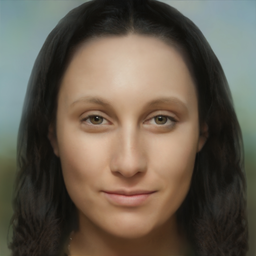

In [0]:
#@title #**Загружаем фото с лицом** { display-mode: "form" }
from google.colab import files

!rm -rf raw_images/
!mkdir raw_images/
#@markdown *Введите ссылку на изображение или оставьте поле **url** пустым (в таком случае будет предложено загрузить фото с компьютера).*
url = '' #@param {type:"string"}
if url == '':
  uploaded = files.upload()
  for fp in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fp, length=len(uploaded[fp])))
else:
  try:
    !wget $url
    fp = url.split('/')[-1]
  except BaseException:
    print("Что-то пошло не так. Попробуйте загрузить фото с компьютера")

fn = 'photo.'+ fp.split('.')[1]
!mv $fp raw_images/$fn
clear_output()
print("Фото загружено:\n")

img1 = PIL.Image.open('raw_images/'+fn)
wpercent = (256/float(img1.size[0]))
hsize = int((float(img1.size[1])*float(wpercent)))
img1 = img1.resize((256,hsize), PIL.Image.LANCZOS)
display(img1)

In [0]:
#@title #**Обрезаем фотографию** { display-mode: "form" }
!rm -rf aligned_images/
!mkdir aligned_images/
!python align_images.py raw_images/ aligned_images/
align = !ls aligned_images
clear_output()
for i in align:
  display(PIL.Image.open('aligned_images/'+i).resize((256,256)))

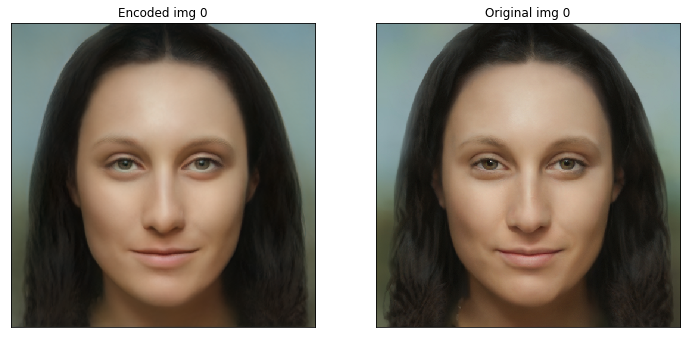


CPU times: user 4.37 s, sys: 562 ms, total: 4.93 s
Wall time: 13min 40s


In [0]:
#@title #**Обучаем нейронную сеть (~15-20 мин.)** { display-mode: "form" }
%%time
!rm -rf latent_representations/ generated_images/
#@markdown **Выберите метод кодирования изображения:**

#@markdown *Метод "slow" работает в 2 раза дольше, но имеет гораздо более высокое качество.*
metod = 'Slow (high quality)' #@param ["Fast (low quality)", "Slow (high quality)"]
#@markdown **Выберите сеть, соответствующую типу лица на входном изображении:**

#@markdown *Стандартная сеть "default" универсальна, поэтому если сомневаетесь, выбирайте ее.*
network = 'european' #@param ["default", "european", "asian", "asian beauty", "baby"]
if network == 'default':
  network_path = 'networks/' + model
else:
  other_networks = !ls networks/other
  if networks_urls[network][1] in other_networks:
    network_path = 'networks/other/' + networks_urls[network][1]
  else:
    network_url = networks_urls[network][0]
    try:
      !gdown $network_url
      network_name = networks_urls[network][1]
      !mv $network_name networks/other/$network_name
      network_path = 'networks/other/' + network_name
    except BaseException:
      network_pkl = 'networks/other/' + networks_urls[network][1]
#@markdown **Установите количество итераций обучения сети:**

#@markdown *Чем больше число, тем дольше будет обучаться нейросеть. Тем не менее качество от этого будет расти. Рекомендуется: 700*
iterat = 750 #@param {type:"slider", min:100, max:1500, step:50}
#@markdown **Установите коэффициент скорости обучения:**

#@markdown *Чем меньше этот показатель, тем выше качество изображение, однако скорость обучения от этого упадет. Рекомендуется: 0.1*
learning_rate = 0.1 #@param {type:"slider", min:0.01, max:1, step:0.01}

#@markdown **Удаление логов после выполнения этого блока:**
delete_logs = True #@param {type:"boolean"}

if metod == 'Slow (high quality)':
  !python project_images.py \
    aligned_images/ \
    generated_images/ \
    --vgg16-pkl 'networks/vgg16_zhang_perceptual.pkl' \
    --num-steps $iterat \
    --initial-learning-rate $learning_rate \
    --network-pkl $network_path \
    --video=False
  !mkdir latent_representations/
  for i in align:
    vector_name = i.split('.')[0]+'.npy'
    !mv generated_images/$vector_name latent_representations/$vector_name
else:
  !python encode_images.py \
    aligned_images/ \
    generated_images/ \
    latent_representations/ \
    --network_pkl $network_path \
    --image_size 1024 \
    --iterations $iterat \
    --lr $learning_rate \
    --batch_size 2

fn = !ls latent_representations
pass
if delete_logs == True:
  clear_output()
display_sbs('generated_images/', 'aligned_images/', res = 512)

In [0]:
#@title #**Cкачиваем сгенерированный вектор признаков и/или изображение** { display-mode: "form" }

download_vector = True #@param {type:"boolean"}
if download_vector == True:
  files.download("latent_representations/photo_01.npy")

download_picture = True #@param {type:"boolean"}
if download_picture == True:
  files.download("generated_images/photo_01.png")

#@markdown *Нижняя галочка просто покажет миниатюру сгенерированного изображения под этим блоком*
show_image = False #@param {type:"boolean"}
if show_image == True:
  img2 = PIL.Image.open('generated_images/photo_01.png')
  wpercent = (256/float(img2.size[0]))
  hsize = int((float(img2.size[1])*float(wpercent)))
  img2 = img2.resize((256,hsize), PIL.Image.LANCZOS)
  display(img2)


```

```
# <b><font color="red" size="+3" >Преподготовка генератора</font></b>

In [0]:
#@title #**Загружаем свой вектор признаков** { display-mode: "form" }

#@markdown *Данный блок не является обязательным. Если у вас есть сохраненный вектор, то вы можете его загрузить*
from google.colab import files
!rm -rf latent_representations
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

!mkdir latent_representations
!mv $fn latent_representations/$fn
fn = [fn]
clear_output()

In [0]:
#@title #**Устанавливаем генератор изображения** { display-mode: "form" }

#@markdown *Ниже выберите ту сеть, в которой генерировали вектор признаков*
network = 'european' #@param ["default", "european", "asian", "asian beauty", "baby"]

if network == 'default':
  network_pkl = 'networks/' + model
else:
  other_networks = !ls networks/other
  if networks_urls[network][1] in other_networks:
    network_pkl = 'networks/other/' + networks_urls[network][1]
  else:
    network_url = networks_urls[network][0]
    try:
      !gdown $network_url
      network_name = networks_urls[network][1]
      !mv $network_name networks/other/$network_name
      network_pkl = 'networks/other/' + network_name
    except BaseException:
      network_pkl = 'networks/other/' + networks_urls[network][1]

tflib.init_tf()
with open(network_pkl, "rb") as f:
  generator_network, discriminator_network, Gs_network = pickle.load(f)

w_avg = Gs_network.get_var('dlatent_avg')
noise_vars = [var for name, var in Gs_network.components.synthesis.vars.items() if name.startswith('noise')]
Gs_syn_kwargs = dnnlib.EasyDict()
Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_syn_kwargs.randomize_noise = False
Gs_syn_kwargs.minibatch_size = 1
truncation_psi = 0.5
clear_output()

```

```
# <b><font color="red" size="+3" >Генерируем фото и анимацию</font></b>

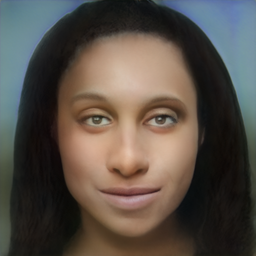

In [0]:
#@title #**Модифицируем лицо по определенному параметру** { run: "auto", display-mode: "form" }
from google.colab import files

v = np.load('latent_representations/'+fn[0])
v = np.array([v]) # если будет не похоже, то можно поэкспериментировать с (* truncation_psi)
!rm -rf results/$direction_name

#@markdown **Выберите, что именно вы бы хотели изменить:**
parameter = 'race_black' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file = parameter + '.npy'
direction_name = direction_file.split('.')[0]
#@markdown **Интенсивность параметра:**
intensity = 5 #@param {type:"slider", min:-20, max:20, step:0.2}
#@markdown *Если поставить галочку на boost_intensity, то интенсивность усилится в 3 раза.*
boost_intensity = True #@param {type:"boolean"}
if boost_intensity == True:
  intensity *= 3
coeffs = [intensity]
#@markdown **Разрешение изображения:**
resolution = "256" #@param [128, 256, 512, 1024]
size = int(resolution), int(resolution)

move_latent_and_save(v, direction_file, coeffs, Gs_network, Gs_syn_kwargs)

In [0]:
#@title #**Анимируем модификацию лица** { display-mode: "form" }
from google.colab import files

v = np.load('latent_representations/'+fn[0])
v = np.array([v]) # если будет не похоже, то можно поэкспериментировать с (* truncation_psi)
!rm -rf results/$direction_name

#@markdown **Выберите, что именно вы бы хотели изменить:**
parameter = 'eyes_open' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file = parameter + '.npy'
direction_name = direction_file.split('.')[0]
#@markdown **Стартовая интенсивность:**
start_intensity = 0 #@param {type:"slider", min:-20, max:20, step:0.2}
#@markdown **Финишная интенсивность:**
finish_intensity = 10 #@param {type:"slider", min:-20, max:20, step:0.2}
#@markdown **Количество кадров:**
frames = 40 #@param {type:"slider", min:10, max:100, step:1}

if finish_intensity > start_intensity:
  #@markdown *Если поставить галочку на boost_intensity, то интенсивность усилится в 3 раза.*
  boost_intensity = True #@param {type:"boolean"}
  if boost_intensity == True:
    start_intensity *= 3
    finish_intensity *= 3
  
  duration = abs(start_intensity)+abs(finish_intensity)
  steps = round(duration/frames,2)
  coeffs = []

  for i in range(int(start_intensity*100), int(finish_intensity*100), int(steps*100)):
    coeffs.append(i/100)
  #@markdown **Разрешение анимации:**
  resolution = "256" #@param [128, 256, 512, 1024]
  size = int(resolution), int(resolution)

  move_latent_and_save(v, direction_file, coeffs, Gs_network, Gs_syn_kwargs)

  #@markdown **Добавить инвертирование:**

  #@markdown *Анимация, дойдя до конца, будет воспроизводиться в обратном порядке. Данная опция увеличивает размер файла в 2 раза.*
  add_invert = True #@param {type:"boolean"}
  face_img = []
  img = os.listdir("results/"+direction_name)
  img.sort()
  for i in img:
    face_img.append(imageio.imread("results/" + direction_name + "/"+i))
  if add_invert == True:
    for j in reversed(face_img):
      face_img.append(j)
  face_img = np.array(face_img)
  imageio.mimsave("results/" + direction_name + "/" + direction_name + ".mp4", face_img)
  display(mpy.ipython_display("results/" + direction_name + "/" + direction_name + ".mp4", height=400, autoplay=1, loop=1))
else:
  print('Стартовая интенсивность должна быть меньше финишной!')

```

```
# <b><font color="red" size="+3" >Дополнительные возможности</font></b>

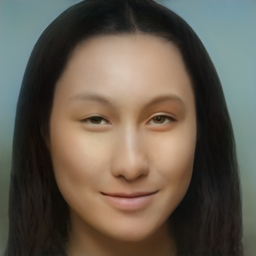

In [0]:
#@title #**Модифицируем лицо по 3 параметрам** { display-mode: "form" }
from google.colab import files

v = np.load('latent_representations/'+fn[0])
v = np.array([v]) # если будет не похоже, то можно поэкспериментировать с (* truncation_psi)
!rm -rf results/3param

#@markdown **Выберите первый параметр:**
parameter1 = 'angle_horizontal' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file1 = np.load('latent_directions/' + parameter1 + '.npy')
intensity1 = 7 #@param {type:"slider", min:-20, max:20, step:0.2}
boost_intensity1 = True #@param {type:"boolean"}
if boost_intensity1 == True:
  intensity1 *= 3

#@markdown **Выберите второй параметр:**
parameter2 = 'race_yellow' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file2 = np.load('latent_directions/' + parameter2 + '.npy')
intensity2 = 5 #@param {type:"slider", min:-20, max:20, step:0.2}
boost_intensity2 = True #@param {type:"boolean"}
if boost_intensity2 == True:
  intensity2 *= 3

#@markdown **Выберите третий параметр:**
parameter3 = 'emotion_happy' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file3 = np.load('latent_directions/' + parameter3 + '.npy')
intensity3 = 4 #@param {type:"slider", min:-20, max:20, step:0.2}
boost_intensity3 = True #@param {type:"boolean"}
if boost_intensity3 == True:
  intensity3 *= 3

#@markdown **Разрешение изображения:**
resolution = "256" #@param [128, 256, 512, 1024]
size = int(resolution), int(resolution)

def move_latent_and_save_3_param(latent_vector, direction_intensity, Gs_network, Gs_syn_kwargs):
    os.makedirs('results/3param', exist_ok=True)
    new_latent_vector = latent_vector.copy()
    new_latent_vector[0][:8] = (latent_vector[0] + direction_intensity)[:8]
    images = Gs_network.components.synthesis.run(new_latent_vector, **Gs_syn_kwargs)
    result = PIL.Image.fromarray(images[0], 'RGB')
    result.thumbnail(size, PIL.Image.ANTIALIAS)
    result.save('results/3param/result_3param.png')
    return result

direction_intensity = (direction_file1*intensity1) + (direction_file2*intensity2) + (direction_file3*intensity3)
move_latent_and_save_3_param(v, direction_intensity, Gs_network, Gs_syn_kwargs)

In [0]:
#@title #**Анимируем модификацию лица (3 параметра)** { display-mode: "form" }
from google.colab import files

v = np.load('latent_representations/'+fn[0])
v = np.array([v]) # если будет не похоже, то можно поэкспериментировать с (* truncation_psi)
!rm -rf results/3param

#@markdown **Количество кадров:**
frames = 40 #@param {type:"slider", min:10, max:100, step:1}

#@markdown **Выберите первый параметр:**
parameter1 = 'angle_horizontal' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file1 = np.load('latent_directions/' + parameter1 + '.npy')
intensity1 = 10 #@param {type:"slider", min:-20, max:20, step:0.2}
if intensity1 == 0: intensity1 += 0.001
boost_intensity1 = True #@param {type:"boolean"}
if boost_intensity1 == True:
  intensity1 *= 3
coeffs1 = []
for i in range(0, frames):
  coeffs1.append(round((i*intensity1)/frames,3))

#@markdown **Выберите второй параметр:**
parameter2 = 'race_yellow' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file2 = np.load('latent_directions/' + parameter2 + '.npy')
intensity2 = 8 #@param {type:"slider", min:-20, max:20, step:0.2}
if intensity2 == 0: intensity2 += 0.001
boost_intensity2 = True #@param {type:"boolean"}
if boost_intensity2 == True:
  intensity2 *= 3
coeffs2 = []
for i in range(0, frames):
  coeffs2.append(round((i*intensity2)/frames,3))

#@markdown **Выберите третий параметр:**
parameter3 = 'emotion_happy' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file3 = np.load('latent_directions/' + parameter3 + '.npy')
intensity3 = 7 #@param {type:"slider", min:-20, max:20, step:0.2}
if intensity3 == 0: intensity3 += 0.001
boost_intensity3 = True #@param {type:"boolean"}
if boost_intensity3 == True:
  intensity3 *= 3
coeffs3 = []
for i in range(0, frames):
  coeffs3.append(round((i*intensity3)/frames,3))

#@markdown **Разрешение анимации:**
resolution = "256" #@param [128, 256, 512, 1024]
size = int(resolution), int(resolution)

def move_latent_and_save_3_param(latent_vector, direction_intensity, frame_num, Gs_network, Gs_syn_kwargs):
    os.makedirs('results/3param', exist_ok=True)
    new_latent_vector = latent_vector.copy()
    new_latent_vector[0][:8] = (latent_vector[0] + direction_intensity)[:8]
    images = Gs_network.components.synthesis.run(new_latent_vector, **Gs_syn_kwargs)
    result = PIL.Image.fromarray(images[0], 'RGB')
    result.thumbnail(size, PIL.Image.ANTIALIAS)
    result.save('results/3param/result_(' + str(frame_num+1000) + ')_3param.png')
    return result

for i in range(frames):
  direction_intensity1 = direction_file1 * coeffs1[i]
  direction_intensity2 = direction_file2 * coeffs2[i]
  direction_intensity3 = direction_file3 * coeffs3[i]
  direction_intensity = direction_intensity1 + direction_intensity2 + direction_intensity3
  move_latent_and_save_3_param(v, direction_intensity, i, Gs_network, Gs_syn_kwargs)
  #clear_output()
  #print('Сгенерированно ' + str(i) + ' фото из ' + str(frames))

#@markdown **Добавить инвертирование:**

#@markdown *Анимация, дойдя до конца, будет воспроизводиться в обратном порядке. Данная опция увеличивает размер файла в 2 раза.*
add_invert = True #@param {type:"boolean"}
face_img = []
img = os.listdir("results/3param")
img.sort()
clear_output()
print('Анимация формируется. Пожалуйста подождите.')
for i in img:
  face_img.append(imageio.imread("results/3param/"+i))
if add_invert == True:
  for j in reversed(face_img):
    face_img.append(j)
face_img = np.array(face_img)
imageio.mimsave("results/3param/3param.mp4", face_img)
display(mpy.ipython_display("results/3param/3param.mp4", height=400, autoplay=1, loop=1))

Анимация формируется. Пожалуйста подождите.
